In [2]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn


import embedding as emb
reload(emb)
from embedding import *

import analysis_helpers

#### Load in pre-computed VGG features

In [116]:
layers = ['P1','P2','P3','P4','P5','FC6','FC7']
## load in and preprocess metadata associated with pre-computed VGG features
meta = pd.read_csv('./data/METADATA.csv')
meta = meta.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
meta['subj'] = meta['subj'].map(lambda x: x.split('_')[0])

## load in vgg features (already preprocessed)
this_layer = 'FC7'
feats = np.load('./data/FEATURES_{}.npy'.format(this_layer))

#### Load in pre-computed neural classifier outputs

In [94]:
## load in neural logistic regression predictions
this_roi = 'V1' ## roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']
path_to_neural_feats = '/home/jefan/neurosketch/data'
neural_logistic_timeseries = 'difference_logprobs_4way_{}_trial_num.csv'.format(this_roi)
N = pd.read_csv(os.path.join(path_to_neural_feats,neural_logistic_timeseries))
# N = pd.read_csv(neural_logistic_timeseries)

## re-format 'sub' column to make sure they are the right length
subs = N['sub'].values
subs = [str(sub).zfill(7) for sub in subs]
N['sub'] = subs

#### Load in baseline sketch features and labels to train classifier (from various layers)

In [86]:
### load in and extract baseline features to use to make predictions on drawing features
reload(analysis_helpers)
path_to_baselines = '../baseline_sketches'
baseline_paths = sorted(analysis_helpers.list_files(path_to_baselines))
def get_label_from_baseline_path(path):
    return path.split('/')[-1].split('_')[0]
def get_view_from_baseline_path(path):
    return path.split('/')[-1].split('_')[1]
def get_instance_from_baseline_path(path):
    return path.split('/')[-1].split('_')[2]

baseline_labels = map(get_label_from_baseline_path,baseline_paths)
baseline_views = map(get_view_from_baseline_path,baseline_paths)
baseline_instances = map(get_instance_from_baseline_path,baseline_paths)
B = pd.read_csv(os.path.join(path_to_baselines,'baseline_sketches_metadata.csv'))

if not os.path.exists('./data'):
    os.makedirs('./data')

## re-extract baseline features if not already pre-computed    
import embedding as emb
reload(emb)
from embedding import *    
extract_baseline = 0
for layer_num in np.arange(6,7):
    if extract_baseline:
        print 'Extracting {}'.format(layers[layer_num])        
        BaselineFeatureExtractor = FeatureExtractor(baseline_paths,layer_num)
        BaselineFeatures, BaselineLabels = BaselineFeatureExtractor.extract_feature_matrix()
        np.save('./data/FEATURES_BASELINE_{}.npy'.format(layers[layer_num]), BaselineFeatures)
        np.save('./data/LABELS_BASELINE.npy',baseline_labels)  
        
## load in baseline features for specific layer and normalize (preprocess)
BaselineFeatures = np.load('./data/FEATURES_BASELINE_{}.npy'.format(this_layer))
normalize_on = 1
if normalize_on:
    BaselineFeatures = analysis_helpers.normalize(BaselineFeatures)    
BaselineLabels = np.load('./data/LABELS_BASELINE.npy')

## train logistic classifier on baseline sketches only
clf = linear_model.LogisticRegression(penalty='l2',C=1,random_state=1).fit(BaselineFeatures, BaselineLabels) 

## overall accuracy on sketches from our study
print clf.score(feats, meta.label.values)

Accuracy: 0.775
Correlation between vgg and neural classifier output across trials: r = 0.583866767675
Accuracy: 0.725
Correlation between vgg and neural classifier output across trials: r = -0.0831791569798
Accuracy: 0.875
Correlation between vgg and neural classifier output across trials: r = 0.0472345411467
Accuracy: 0.85
Correlation between vgg and neural classifier output across trials: r = 0.230978726047
Accuracy: 0.6
Correlation between vgg and neural classifier output across trials: r = -0.231680997058
Accuracy: 0.675
Correlation between vgg and neural classifier output across trials: r = 0.282957959071
Accuracy: 0.9
Correlation between vgg and neural classifier output across trials: r = 0.0874253639481
Accuracy: 0.875
Correlation between vgg and neural classifier output across trials: r = 0.476469715677
Accuracy: 0.825
Correlation between vgg and neural classifier output across trials: r = 0.534358171252
Accuracy: 0.725
Correlation between vgg and neural classifier output acro

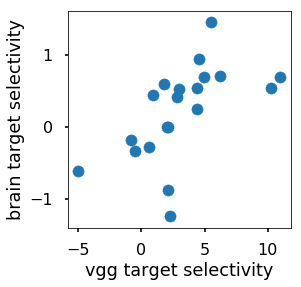

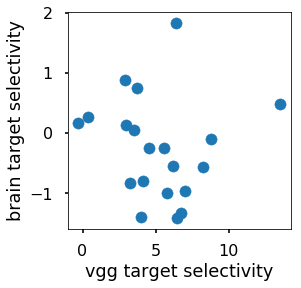

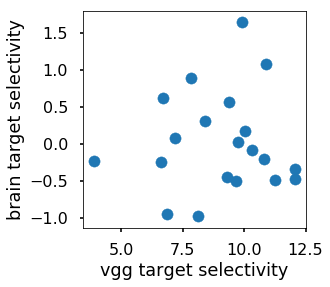

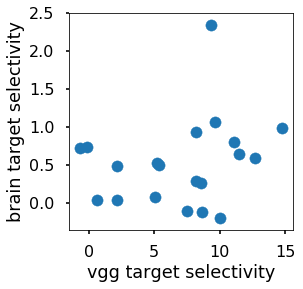

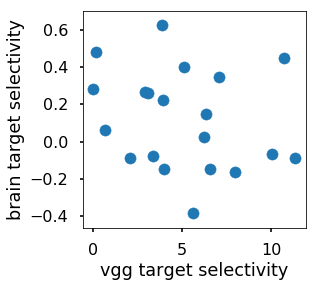

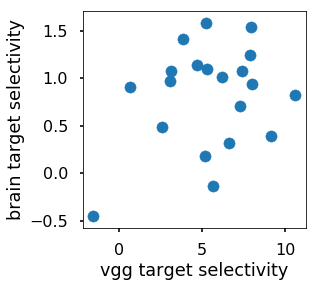

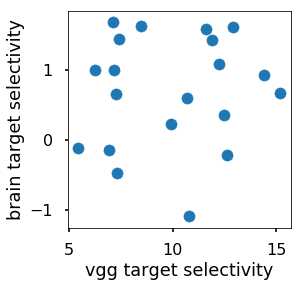

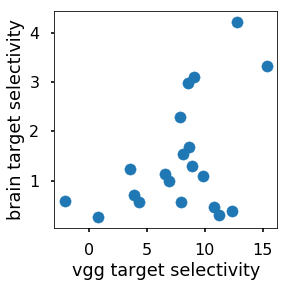

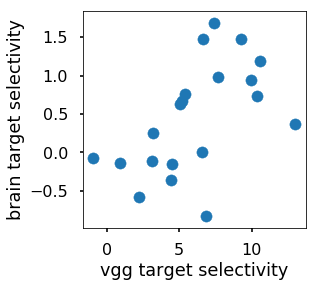

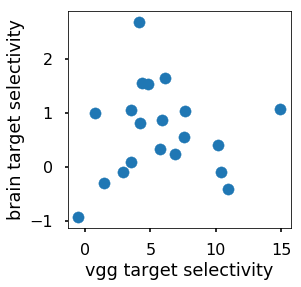

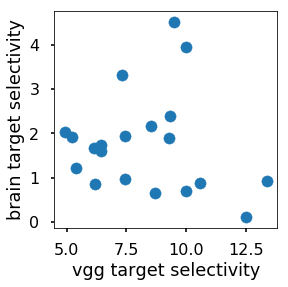

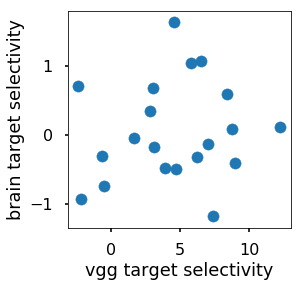

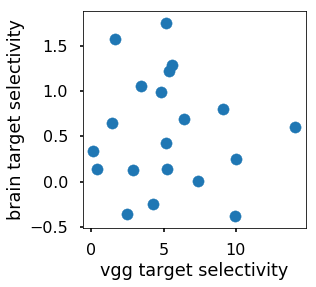

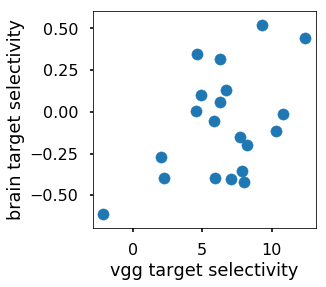

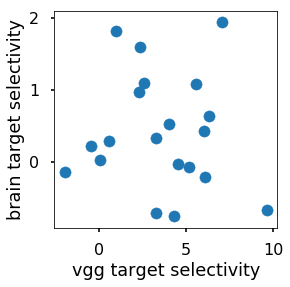

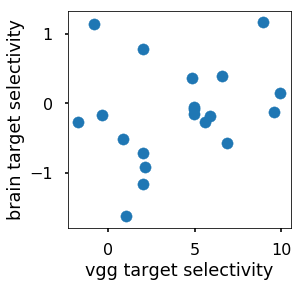

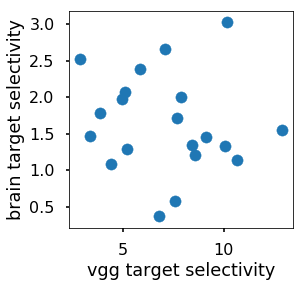

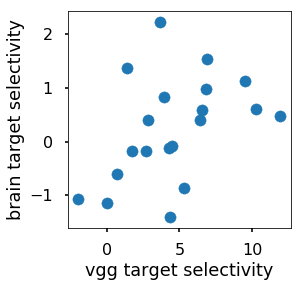

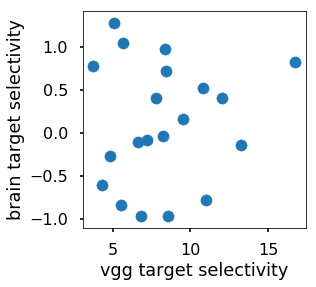

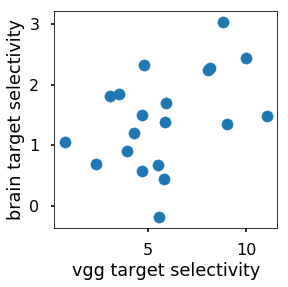

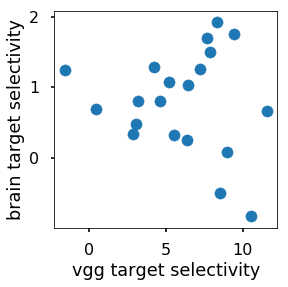

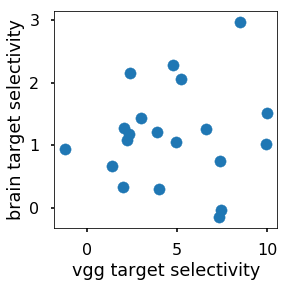

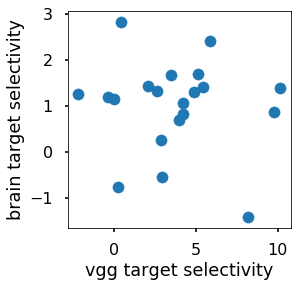

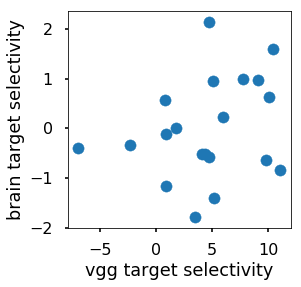

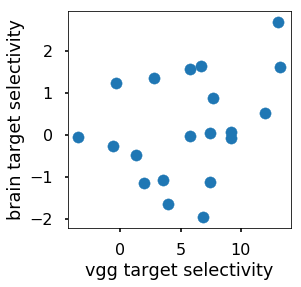

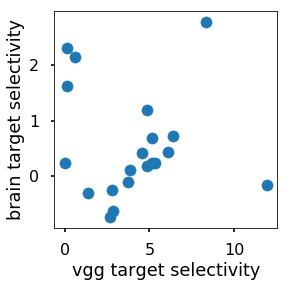

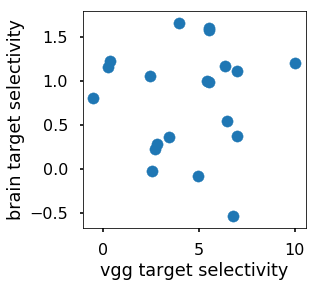

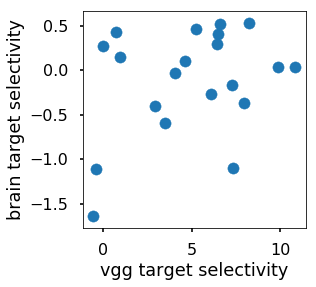

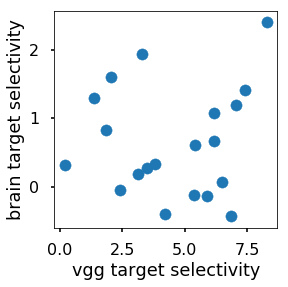

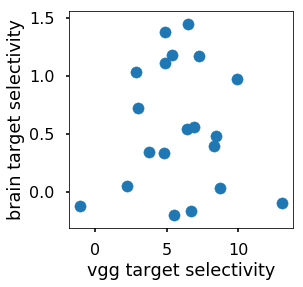

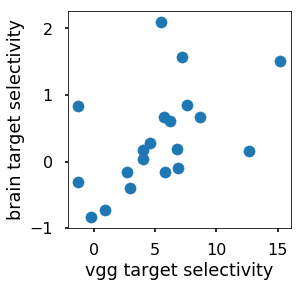

In [112]:
## define list of subjects for which we have neural data on
sub_list = np.unique(N['sub'].values)
sub = sub_list[2]

## loop through subjects
vgg_neural_correspondence = []
for sub in sub_list:

    ## use logged probabilities
    logged=True

    ## subset group meta by trials from this individual subject
    inds = (meta['subj']==sub)
    _meta = meta[inds]
    _meta = _meta.sort_values(['trial'])
    _inds = _meta.index

    ## subset skethc features and labels from this subject
    test_feats = feats[_inds,:]
    test_labels = _meta.label.values

    ## get classification accuracy for this subject
    print_acc = 0
    if print_acc:
        print 'Accuracy: {}'.format(clf.score(test_feats, test_labels))

    ## add prediction probabilities to metadata matrix
    cats = clf.classes_
    probs = clf.predict_proba(test_feats)

    ## what were trained vs. control objectss
    trained_objs = np.unique(test_labels)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]

    ## re-order so that it you have the two trained objects first, followed by the control objects
    _ordering = np.argsort(np.hstack((trained_objs,control_objs))) ## e.g., [chair table bench bed] ==> [3 2 0 1]
    ordering = np.argsort(_ordering) ## get indices that sort from alphabetical to (trained_objs, control_objs)
    probs = clf.predict_proba(test_feats)[:,ordering] ## [table chair bed bench] 
    logprobs = np.log(clf.predict_proba(test_feats)[:,ordering])

    if logged==True:
        out = logprobs
    else:
        out = probs

    _meta['t1_prob'] = out[:,0]
    _meta['t2_prob'] = out[:,1]
    _meta['c1_prob'] = out[:,2]
    _meta['c2_prob'] = out[:,3]

    ## also save out new columns in the same order 
    if logged==True:
        probs = np.log(clf.predict_proba(test_feats))
    else:
        probs = clf.predict_proba(test_feats)
    _meta['bed_prob'] = probs[:,0]
    _meta['bench_prob'] = probs[:,1]
    _meta['chair_prob'] = probs[:,2]
    _meta['table_prob'] = probs[:,3]                 

    ## get timecourse of target selectivity (log(t/f)) based on model 
    t,f,c = analysis_helpers.get_prob_timecourse('trial',_meta,version='4way')
    vgg_targ_select = t-f

    ## get timecourse of target selectivity (log(t/f)) based on BRAIN 
    brain_targ_select = N[(N['sub']==sub) & (N['condition']=='target-foil')]['probability'].values

    ## plot
    plotting=0
    if plotting:
        plt.figure(figsize=(4,4))
        plt.scatter(vgg_targ_select,brain_targ_select)
        plt.xlabel('vgg target selectivity')
        plt.ylabel('brain target selectivity')
        r,p = stats.pearsonr(vgg_targ_select,brain_targ_select)
        vgg_neural_correspondence.append(r)
        print 'Correlation between vgg and neural classifier output across trials: r = {}'.format(r)

In [127]:
X_train, X_test, y_train, y_test = train_test_split(
    BaselineFeatures, BaselineLabels, test_size=0.25, random_state=0)
clf = linear_model.LogisticRegression(penalty='l2',C=1,random_state=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

0.8214285714285714


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    feats, meta.label.values, test_size=0.25, random_state=0)
clf = linear_model.LogisticRegression(penalty='l2',C=1,random_state=1).fit(X_train, y_train)
print clf.score(X_test, y_test)